In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from ens_util import *
from math import isnan
from sklearn.calibration import calibration_curve
plt.rcParams['figure.figsize'] = [9,9]

In [2]:
data_files = glob('data_crop*.nc')
#res_files = glob('2014*Z_crs_gauss.nc')
coordx = [258]
coordy = [63]
thresh = 0.2
data = build_datadf(data_files,coordx,coordy)
(fr15,fr30,fr45,fr60) = build_benchmark_fractions(data_files,data.index,thresh)
fr = [fr15,fr30,fr45,fr60]

data_crop_04_02.nc
data_crop_04_05.nc
data_crop_04_09.nc
data_crop_04_10.nc
data_crop_04_11.nc
data_crop_04_12.nc
data_crop_04_15.nc
data_crop_04_18.nc
data_crop_04_19.nc
data_crop_04_20.nc
data_crop_04_21.nc
data_crop_04_22.nc
data_crop_04_25.nc
data_crop_04_26.nc
data_crop_05_05.nc
data_crop_05_06.nc
data_crop_05_07.nc
data_crop_05_08.nc
data_crop_05_09.nc
data_crop_05_19.nc
data_crop_05_20.nc
data_crop_05_21.nc
data_crop_05_22.nc
data_crop_05_23.nc
data_crop_05_24.nc
data_crop_05_25.nc
data_crop_05_29.nc
data_crop_05_30.nc
data_crop_06_03.nc
data_crop_06_10.nc
data_crop_06_11.nc
data_crop_06_12.nc
data_crop_06_14.nc
data_crop_06_15.nc
data_crop_06_16.nc
data_crop_06_17.nc
data_crop_06_18.nc
data_crop_06_19.nc
data_crop_06_22.nc


In [3]:
index_dates = data.index.date
index_dates_unique = np.unique(index_dates)
index_times = data.index
bs15 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs30 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs45 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs60 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs = [bs15,bs30,bs45,bs60]

In [4]:
#Better way to do the brier score calculations

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

for c in data.columns:
    for d in index_dates_unique:
        times = index_times[np.where(index_dates==d)]
        sat = data_bin.loc[times,[c]]
        for f in range(4):
            frac = fr[f].loc[times,[c]]
            bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
            valid = np.where(np.invert(np.isnan(bs_vals)))
            bs[f].at[d,c] = np.sum(bs_vals[valid])/len(bs_vals[valid])

In [5]:
#Brier Score decomposition
c=0
f=0
d=index_dates_unique[0]
times = index_times[np.where(index_dates==d)]
sat = data_bin.loc[times,[c]]
frac = fr[f].loc[times,[c]]

bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
sat_vals = sat.values[:,0].astype(np.float)
frac_vals = frac.values[:,0].astype(np.float)

valid = np.where(np.invert(np.isnan(bs_vals)))
bs_valid = bs_vals[valid]
sat_valid = sat_vals[valid]
frac_valid = frac_vals[valid]
print(bs_valid,sat_valid,frac_valid)

[1.79368622e-06 7.97193878e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.76562500e-06 8.68144133e-04
 2.84765625e-02 4.96255182e-02 2.46938776e-02 4.48421556e-03
 1.79368622e-02 1.49625319e-02 1.56250000e-04 1.56250000e-04
 1.34725765e-04 2.87786990e-04] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.99866071 0.99910714 1.         1.         1.         1.
 0.996875   0.97053571 0.83125    0.77723214 0.84285714 0.93303571
 0.86607143 0.87767857 0.9875     0.9875     0.98839286 0.98303571]


In [6]:
# Follows Wilks Ch. 8
unique,counts = np.unique(frac_valid,return_counts=True) #counts are N_i values
n = np.sum(counts) # n

obar_i = np.zeros(len(unique))
for j in range(len(unique)):
    y = unique[j]
    wh = np.where(frac_valid==y)
    obar_i[j] = np.sum(sat_valid[wh])/counts[j]

obar = np.sum(sat_valid)/n

sig = obar*(1-obar)
rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n

print(rel,res,sig,rel-res+sig)

0.007877504517431973 0.0 0.0 0.007877504517431973


In [7]:
# would have to create new columns for each coordinate location
dec15 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec30 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec45 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec60 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec = [dec15,dec30,dec45,dec60]

c=0
for d in index_dates_unique:
    times = index_times[np.where(index_dates==d)]
    sat = data_bin.loc[times,[c]]
    for f in range(4):
        frac = fr[f].loc[times,[c]]
        bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
        sat_vals = sat.values[:,0].astype(np.float)
        frac_vals = frac.values[:,0].astype(np.float)
        valid = np.where(np.invert(np.isnan(bs_vals)))
        bs_valid = bs_vals[valid]
        sat_valid = sat_vals[valid]
        frac_valid = frac_vals[valid]
        
        unique,counts = np.unique(frac_valid,return_counts=True)
        n = np.sum(counts)
        obar_i = np.zeros(len(unique))
        for j in range(len(unique)):
            y = unique[j]
            wh = np.where(frac_valid==y)
            obar_i[j] = np.sum(sat_valid[wh])/counts[j]
        obar = np.sum(sat_valid)/n

        sig = obar*(1-obar)
        rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
        res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n
        dec[f].at[d,'rel'] = rel
        dec[f].at[d,'res'] = res
        dec[f].at[d,'sig'] = sig
        dec[f].at[d,'bs'] = rel-res+sig
print(dec30)

                    rel        res        sig           bs  bss
2014-04-02    0.0087055          0          0    0.0087055  NaN
2014-04-05     0.115607    0.17284    0.17284     0.115607  NaN
2014-04-09    0.0501104  0.0524691  0.0524691    0.0501104  NaN
2014-04-10  0.000331819          0          0  0.000331819  NaN
2014-04-11     0.218464    0.17284    0.17284     0.218464  NaN
2014-04-12     0.163832    0.17284    0.17284     0.163832  NaN
2014-04-15     0.093972  0.0987654  0.0987654     0.093972  NaN
2014-04-18            0          0          0            0  NaN
2014-04-19     0.152598       0.25       0.25     0.152598  NaN
2014-04-20   0.00694618          0          0   0.00694618  NaN
2014-04-21  2.00295e-05          0          0  2.00295e-05  NaN
2014-04-22  0.000159107          0          0  0.000159107  NaN
2014-04-25   1.5501e-07          0          0   1.5501e-07  NaN
2014-04-26     0.158738  0.0987654  0.0987654     0.158738  NaN
2014-05-05  5.53607e-08          0      

In [8]:
avg_ci = [0.07326633937050787,
 0.20778712302975885,
 0.11192718638706237,
 0.06896607381887883,
 0.14332269534242617,
 0.25472343970477335,
 0.04777688933358877,
 0.8596485152665307,
 0.19564074560864855,
 0.06170793115020668,
 0.021583633585999476,
 0.03259704694624734,
 0.03989605709146575,
 0.5405269801579695,
 0.013546266323385918,
 0.06124534490048805,
 0.05463109817092926,
 0.03606780100144922,
 0.0638700738320475,
 0.03620355300317931,
 0.04244338007354623,
 0.009881199632866159,
 0.033942529421483604,
 0.009342719017178461,
 0.05944429052055939,
 0.10105394353402507,
 0.6654091999523657,
 0.0021613105745977136,
 0.013400553711767014,
 0.017006162006099224,
 0.09350540001254598,
 0.10001397910002892,
 0.006636670686108557,
 0.09580385996389294,
 0.08552496468202024,
 0.16219456934530282,
 0.10637936657699525,
 0.017298070474985355,
 0.0015729371576519585]

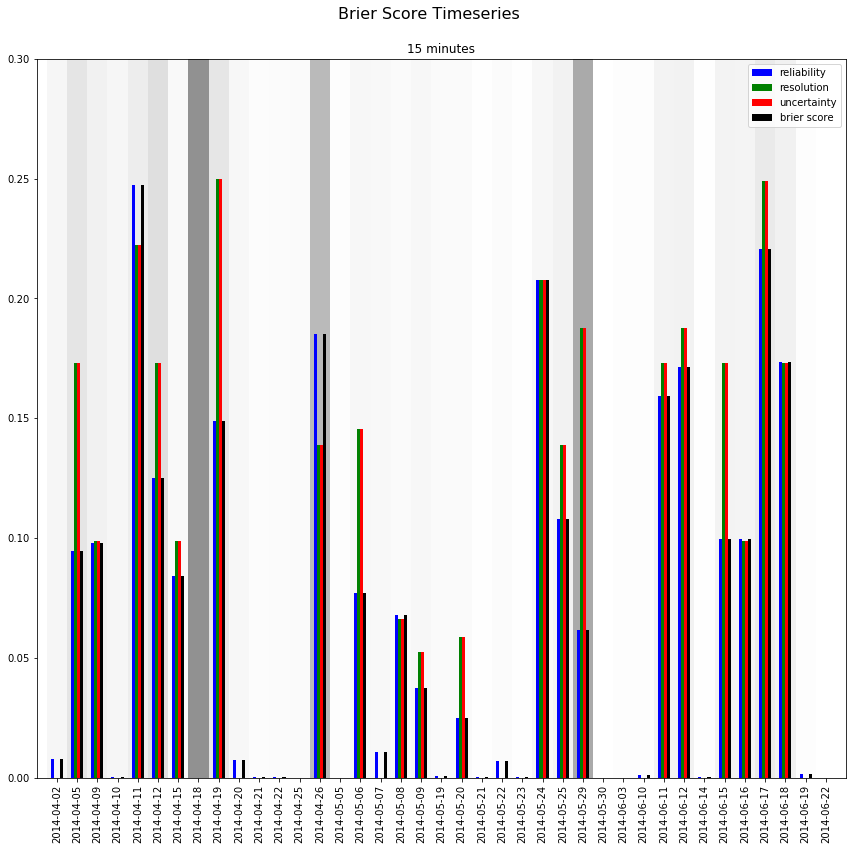

In [9]:
plt.rcParams['figure.figsize'] = [12,12]
ymin= 0
ymax = 0.3
rows = 1; cols = 1;

x = list(dec15.index)
xpos = np.array(range(len(x)))+1
width = 0.15
dx = width/2

fig,ax = plt.subplots(rows,cols)
ax.set_ylim([ymin,ymax])
ax.set_xlim([0,len(xpos)+1])
ax.set_xticks(xpos)
ax.set_xticklabels(x,rotation='vertical')

ax.bar(xpos-3*dx,dec15.values[:,0],width=width,color='b',label='reliability')
ax.bar(xpos-dx,dec15.values[:,1],width=width,color='g',label='resolution')
ax.bar(xpos+dx,dec15.values[:,2],width=width,color='r',label='uncertainty')
ax.bar(xpos+3*dx,dec15.values[:,3],width=width,color='k',label='brier score')

for i in range(1,len(x)+1):
    alpha = 0.5*avg_ci[i-1]
    ax.fill_between(np.arange(i-0.5,i+0.501,0.1),0,0.3,facecolor='k',alpha=alpha)

ax.set_title("15 minutes")

#fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.legend()
plt.show()

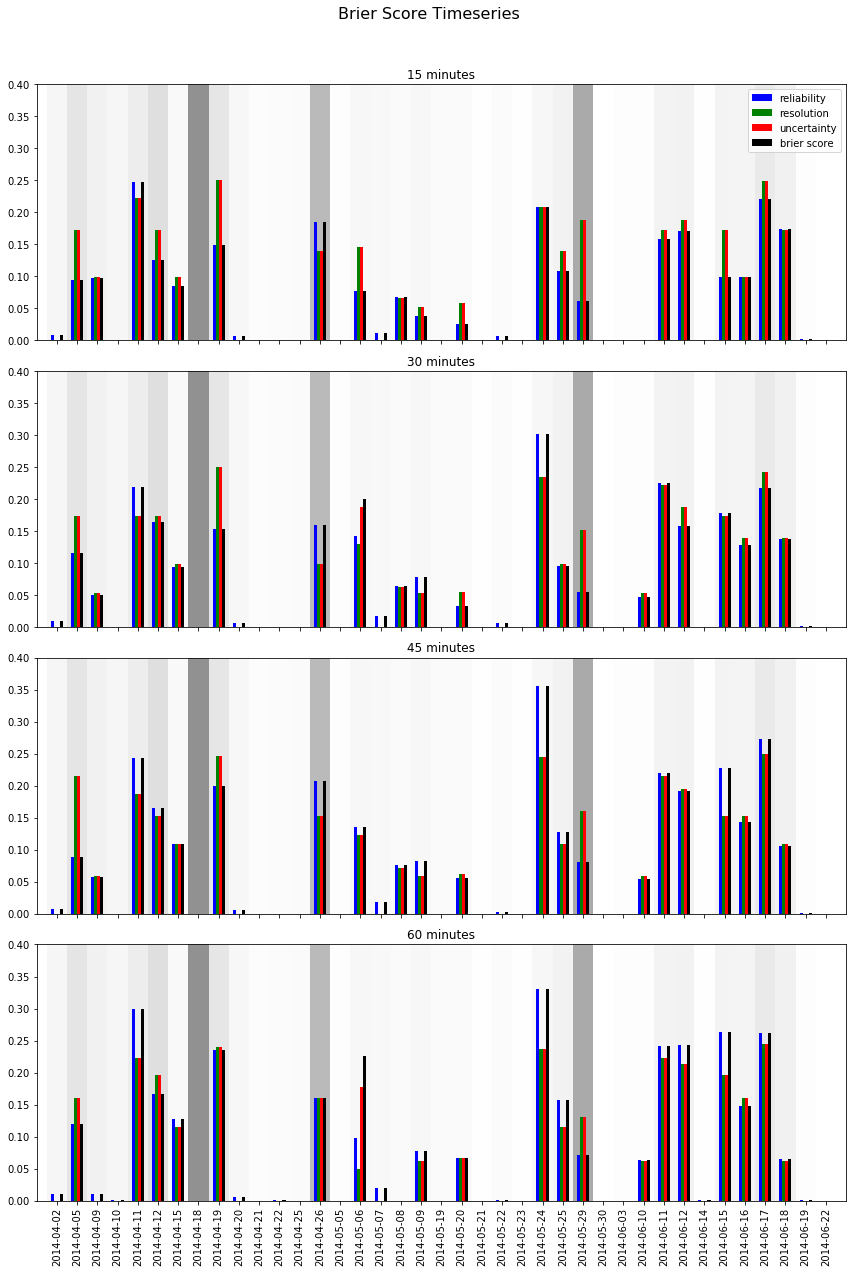

In [10]:
plt.rcParams['figure.figsize'] = [12,18]
ymin= 0
ymax = 0.4
rows = 4; cols = 1;
fig,ax = plt.subplots(rows,cols,sharex=True)
for r in range(rows):
    for c in range(cols):
        ax[r].set_ylim([ymin,ymax])
        ax[r].set_xlim([0,len(xpos)+1])
        ax[r].set_xticks(xpos)
        ax[r].set_xticklabels(x,rotation='vertical')
        
ax[0].bar(xpos-3*dx,dec15.values[:,0],width=width,color='b',label='reliability')
ax[0].bar(xpos-dx,dec15.values[:,1],width=width,color='g',label='resolution')
ax[0].bar(xpos+dx,dec15.values[:,2],width=width,color='r',label='uncertainty')
ax[0].bar(xpos+3*dx,dec15.values[:,3],width=width,color='k',label='brier score')

ax[1].bar(xpos-3*dx,dec30.values[:,0],width=width,color='b',label='reliability')
ax[1].bar(xpos-dx,dec30.values[:,1],width=width,color='g',label='resolution')
ax[1].bar(xpos+dx,dec30.values[:,2],width=width,color='r',label='uncertainty')
ax[1].bar(xpos+3*dx,dec30.values[:,3],width=width,color='k',label='brier score')

ax[2].bar(xpos-3*dx,dec45.values[:,0],width=width,color='b',label='reliability')
ax[2].bar(xpos-dx,dec45.values[:,1],width=width,color='g',label='resolution')
ax[2].bar(xpos+dx,dec45.values[:,2],width=width,color='r',label='uncertainty')
ax[2].bar(xpos+3*dx,dec45.values[:,3],width=width,color='k',label='brier score')

ax[3].bar(xpos-3*dx,dec60.values[:,0],width=width,color='b',label='reliability')
ax[3].bar(xpos-dx,dec60.values[:,1],width=width,color='g',label='resolution')
ax[3].bar(xpos+dx,dec60.values[:,2],width=width,color='r',label='uncertainty')
ax[3].bar(xpos+3*dx,dec60.values[:,3],width=width,color='k',label='brier score')

for a in range(4):
    for i in range(1,len(x)+1):
        alpha = 0.5*avg_ci[i-1]
        ax[a].fill_between(np.arange(i-0.5,i+0.501,0.1),0,0.6,facecolor='k',alpha=alpha)

ax[0].set_title("15 minutes")
ax[1].set_title("30 minutes")
ax[2].set_title("45 minutes")
ax[3].set_title("60 minutes")

ax[0].legend()

#fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

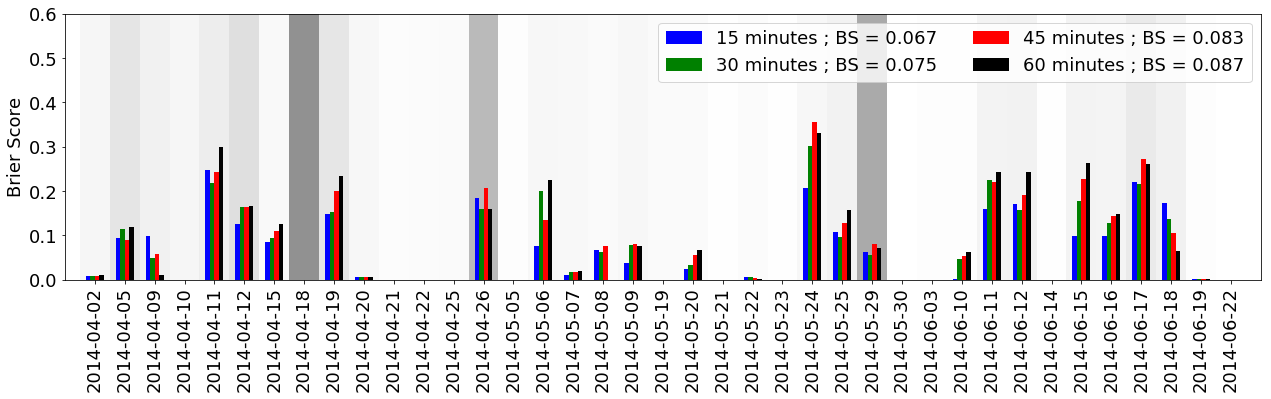

In [14]:
plt.rcParams['figure.figsize'] = [18,6]
plt.rcParams.update({'font.size': 18})
ymin= 0
ymax = 0.6
width = 0.15
rows = 1; cols = 1;
fig,ax = plt.subplots(rows,cols,sharex=True)
ax.set_ylim([ymin,ymax])
ax.set_xlim([0,len(xpos)+1])
ax.set_xticks(xpos)
ax.set_xticklabels(x,rotation='vertical')
ax.set_ylabel('Brier Score')
        
ax.bar(xpos-3*dx,dec15.values[:,3],width=width,color='b',label='15 minutes ; BS = 0.067')
ax.bar(xpos-dx,dec30.values[:,3],width=width,color='g',label='30 minutes ; BS = 0.075')
ax.bar(xpos+dx,dec45.values[:,3],width=width,color='r',label='45 minutes ; BS = 0.083')
ax.bar(xpos+3*dx,dec60.values[:,3],width=width,color='k',label='60 minutes ; BS = 0.087')

for i in range(1,len(x)+1):
    alpha = 0.5*avg_ci[i-1]
    ax.fill_between(np.arange(i-0.5,i+0.501,0.1),ymin,ymax,facecolor='k',alpha=alpha)

ax.legend(loc='upper right',fontsize=18,ncol=2)

#fig.autofmt_xdate()
fig.tight_layout()
#fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

In [12]:
# Overall brier score
# choosing coordinate c=0
c=0

index_dates = data.index.date
index_dates_unique = np.unique(index_dates)
index_times = data.index

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

sat = data_bin.loc[:,[c]]
for f in range(4):
    frac = fr[f].loc[:,[c]]
    bs_df = ((frac-sat)**2)
    times = bs_df.index.values
    bs_vals = bs_df.values[:,0].astype(np.float)
    valid = np.where(np.invert(np.isnan(bs_vals)))
    bs_valid = bs_vals[valid]
    valid_times = times[valid]
    sat_vals = sat.loc[valid_times,[c]].values[:,0]
    obar = np.sum(sat_vals)/len(sat_vals)
    
    brier = np.sum(bs_valid)/len(bs_valid)
    print((f+1)*15,'minutes :',brier)
    #print('BS = ',brier)
    #print('obar = ',obar)

15 minutes : 0.06568814024633289
30 minutes : 0.07517370700372783
45 minutes : 0.0833480861890353
60 minutes : 0.08728302116621693


In [13]:
#climatological benchmark, using y_i = obar

for f in range(4):
    bs_df = ((0.815-sat)**2)
    times = bs_df.index.values
    bs_vals = bs_df.values[:,0].astype(np.float)
    valid = np.where(np.invert(np.isnan(bs_vals)))
    bs_valid = bs_vals[valid]
    valid_times = times[valid]
    sat_vals = sat.loc[valid_times,[c]].values[:,0]
    obar = np.sum(sat_vals)/len(sat_vals)
    
    brier = np.sum(bs_valid)/len(bs_valid)
    print((f+1)*15,'minutes :',brier)
    #print('BS = ',brier)
    #print('obar = ',obar)

15 minutes : 0.14897500000000002
30 minutes : 0.14897500000000002
45 minutes : 0.14897500000000002
60 minutes : 0.14897500000000002


repeat brier score, reliability diagrams for simple average, weighted average of the points where power plants are located.  Put each point as a column in my pd dataframes.  Weighting corresponds to power output.  Include residential output as points near houses? See eia.gov energy mapping system.  Coordinates from Will. 